# Convergence of the DFT calculation
---

In the following exercise we will perform *necessary* step in every DFT study: the convergence analysis. The foundations we use in our work are indeed "from first principles" and have very limited set of parameters - essentially only the geometric setup of the system. However, the actual numerical calculation involves multiple approximations and limiting factors - each one with it's set of control parameters.

Most of these parameters carries out with it some trade-offs, usually speed or memory footprint (or both) against accuracy of the results. In any practical calculations we cannot just crank up all these parameters to the extreme values to hope for the accurate results. This would severely limit the range of applicability of the method to the very simplest systems and made the whole effort almost pointless.

Instead, for each case, we perform the convergence study to find the set of parameters which are well suited to the problem at hand. 

This exercise is an adaptation of the AbInit tutorial. The relevant manuals can be found on the [AbInit documentation site](https://docs.abinit.org/) and [Atomic Simulation Environment (ASE) site](https://wiki.fysik.dtu.dk/ase/index.html).

As usual the calculation starts with importing necessary tools and libraries.

In [1]:
# Command importing plotting and numerical functions
%pylab inline

# Atomic Simulation Environment tools
from ase import Atoms                      # Object representing groups of atoms
from ase.units import Ry, Bohr             # Unit conversion constants
from ase.calculators.abinit import Abinit  # AbInit DFT program interface
from ase.visualize.plot import plot_atoms  # Simple plotting function

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Construction of the molecule

We continue with our object from the first exercise - the Hydrogen molecule.
We build the H$_2$ molecule inside a 10x10x10 Angstrom box. The atoms are separated by 1A distance. We check the result by simple plot.

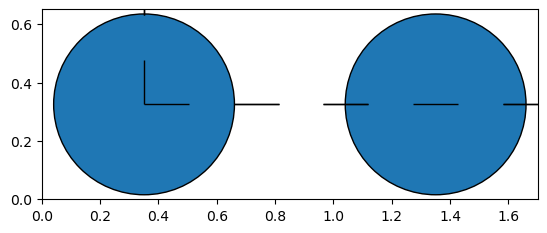

In [2]:
H2 = Atoms("H2", positions=[(0,0,0),(1,0,0)], cell=[10, 10, 10])
plot_atoms(H2, colors=2*['C0'], show_unit_cell=1);

### Defining DFT calculator

This part will be a focus of our exercise. The calculator object is created with a number of explicit parameters and a large set of default values. Here we will go only over a small subset of parameters, leaving a more comprehensive study as an exercise. Let us recall the basic set of parameters:

#### Organizing parameters
* `directory` working directory for the calculation

#### Calculation setup
* `nbands` number of electronic bands per atom
* `ecut` cutoff energy for the plane wave representation of wavefunctions
* `kpts` grid of k-points for reciprocal space integration
* `toldfe` convergence criterion for electronic states iteration
* `xc` exchange type to use in the calculation (LDA, PBE)
* `pps` variant of the pseudopotential (fhi and hgh are installed, others are available)

This set is *by far* not complete, a complete list can be found on the [AbInit documentation site](https://docs.abinit.org/variables/basic/). 

Previously we have started with the set of parameters tuned to give us optimum speed of calculation. For this exercise we will start with even shorter set of parameters leaving the rest at their default values - to be explored at the later stage. Define the AbInit calculator object with just minimal set of required parameters (`ecut`, `toldfe`, `xc`, `pps`) plus the name of the system and the working directory.

In [3]:
params = {'directory': "work_02",
          'ecut' : 10,
          'toldfe' : 1.0e-4,
          'xc' : 'LDA',
          'pps' : 'fhi'
         }

## Convergence in `ecut`

We start our study from the cutoff energy. This energy determines the set of plane waves (the shortest wavelength) used to represent the wave function of the electrons in the molecule. Our starting value is an absurdly small 20 eV - which is even smaller then the ionization energy of the system. The maximal value is a fairy large 700 eV - a good deal higher then the energies present in the system. We run several iteration of the calculation collecting the data in the results list.

### Energy values convergence

First we will check the convergence of total energy value.

This time we use more traditional for loop for iteration. Since the energy scale is really not linear we space the cutoff values in the logarithmic grid.
Since the calculation produces energies and forces we collect both of them for future analysis.

In [4]:
ecut_min = 20
ecut_max = 700

results = []
for ec in linspace(log(ecut_min), log(ecut_max), 9):
    params['ecut'] = exp(ec)
    H2.calc = Abinit(**params)
    print('%5.1f eV' % (exp(ec),), end=': ')                  # formating using % operator
    results.append([exp(ec), 
                    H2.get_potential_energy(), 
                    H2.get_forces()[0,0]])
    print(f'{H2.get_potential_energy():6.3f} eV')             # formating using f-strings

results = array(results).T                                    # convert to array

 20.0 eV: -20.798 eV
 31.2 eV: -23.914 eV
 48.6 eV: -26.259 eV
 75.9 eV: -27.821 eV
118.3 eV: -28.860 eV
184.5 eV: -29.645 eV
287.8 eV: -30.165 eV
448.8 eV: -30.341 eV
700.0 eV: -30.360 eV


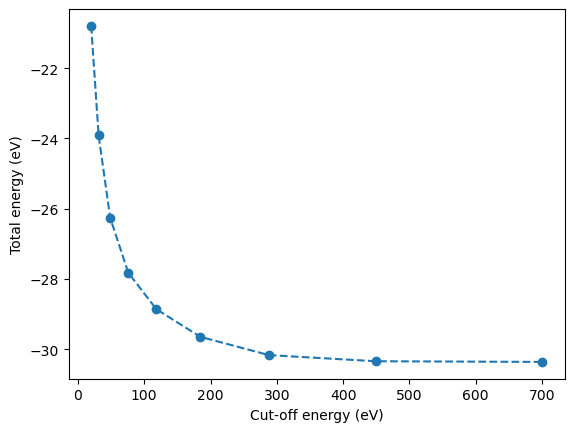

In [5]:
# Plot the convergence
plot(results[0], results[1], 'o--')
xlabel('Cut-off energy (eV)')
ylabel('Total energy (eV)');

### Energy *differences* convergence

Our next goal is to check the energy *difference* convergence. Usually we are not interested in absolute energies - since they are usually defined up to additive constant. Thus, we will compare two molecules with different bond length: 1 A and 0.85 A.

In [6]:
# copy the molecule
H2_2 = Atoms(H2)

# modify the position of the second atom
x0 = 0.85
H2_2.set_positions([(-x0/2,0,0),(x0/2,0,0)])

In [7]:
results_2 = []
for ec in linspace(log(ecut_min), log(ecut_max), 9):
    params['ecut'] = exp(ec)
    H2_2.calc = Abinit(**params)
    print('%5.1f eV' % (exp(ec),), end=': ')                  # formating using % operator
    results_2.append([exp(ec), 
                      H2_2.get_potential_energy(),
                      H2_2.get_forces()[0,0]])
    print(f'{H2_2.get_potential_energy():6.3f} eV')             # formating using f-strings

results_2 = array(results_2).T                                # convert to array

 20.0 eV: -19.277 eV
 31.2 eV: -22.934 eV
 48.6 eV: -25.892 eV
 75.9 eV: -27.981 eV
118.3 eV: -29.258 eV
184.5 eV: -30.067 eV
287.8 eV: -30.604 eV
448.8 eV: -30.818 eV
700.0 eV: -30.842 eV


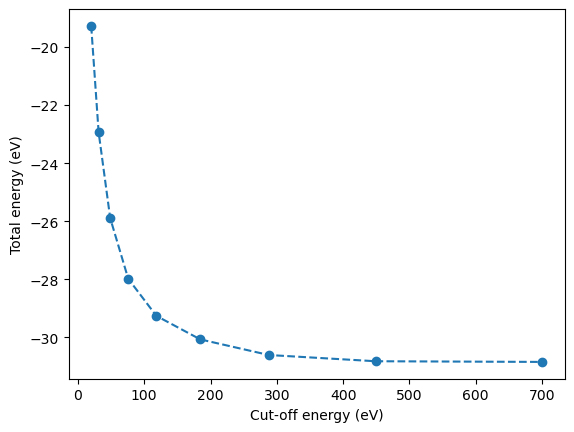

In [8]:
# Plot the convergence
plot(results_2[0], results_2[1], 'o--')
xlabel('Cut-off energy (eV)')
ylabel('Total energy (eV)');

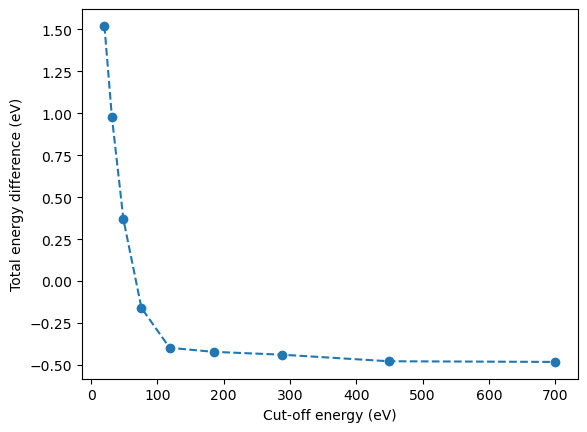

In [9]:
# Plot the difference in energy
plot(results[0], results_2[1]-results[1], 'o--')
xlabel('Cut-off energy (eV)')
ylabel('Total energy difference (eV)');

### Convergence of forces

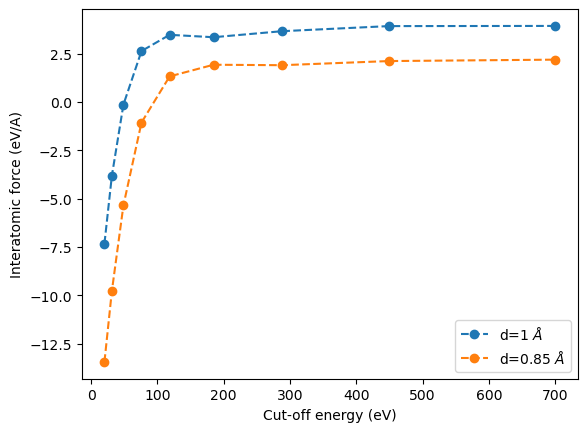

In [10]:
# Plot the convergence
plot(results[0], results[2], 'o--', label='d=1 $\AA$')
plot(results_2[0], results_2[2], 'o--',  label='d=0.85 $\AA$')
xlabel('Cut-off energy (eV)')
ylabel('Interatomic force (eV/A)')
legend();

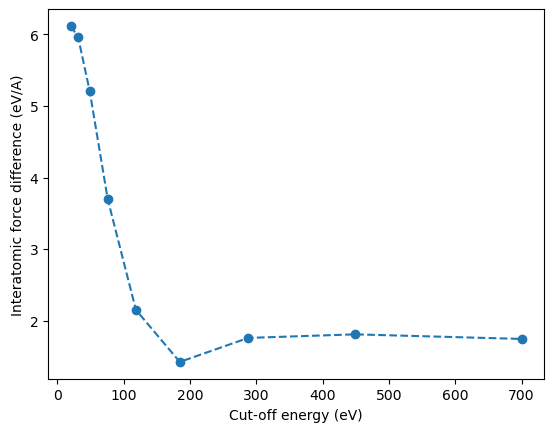

In [11]:
# Plot the convergence
plot(results[0], results[2]-results_2[2], 'o--')
xlabel('Cut-off energy (eV)')
ylabel('Interatomic force difference (eV/A)');

## Convergence in box size

The cutoff energy defines the size of the system in the *momentum* space - by limiting maximum represented energy of an electron.
The size of the box we use in the calculation limits the other side of the spectrum - by limiting the *longest* wavelength possible in the calculation and by insulating images of the calculated system with the layer of vacuum. Unfortunately vacuum is fairly expensive in the plane-wave calculation: empty or not the space must be represented in the basis set. Thus we should use only as much of a vacuum as required by the desired accuracy.

### Running the calculations

We will re-use the objects and calculators from the first exercise. Learning how to modify already constructed system. The scheme of the calculation is very similar we loop over several box sizes and compare energies and forces but this time we will run both calculations together

In [12]:
cell_r = []
params['ecut'] = 150
# params['chksymtnons'] = 0
H2.calc = Abinit(**params)
H2_2.calc = Abinit(**params)
x0 = 0.85

for ls in linspace(log(3), log(15), 7):
    s = exp(ls)
    print(f'{s:.1f}A', end=', ')
    for ats in (H2, H2_2):
        ats.set_cell([s,s,s])

    H2.set_positions([(-1/2,0,0),(1/2,0,0)])    
    H2_2.set_positions([(-x0/2,0,0),(x0/2,0,0)])
    
    cell_r.append([s, 
                   H2.get_potential_energy(), H2.get_forces()[0,0],
                   H2_2.get_potential_energy(), H2_2.get_forces()[0,0]])
print('Done')
cell_r = array(cell_r).T

3.0A, 3.9A, 5.1A, 6.7A, 8.8A, 11.5A, 15.0A, Done


### Analyzing the results

We have collected all the results. Now we can plot and analyze the data: total energy and forces, energy and force difference.

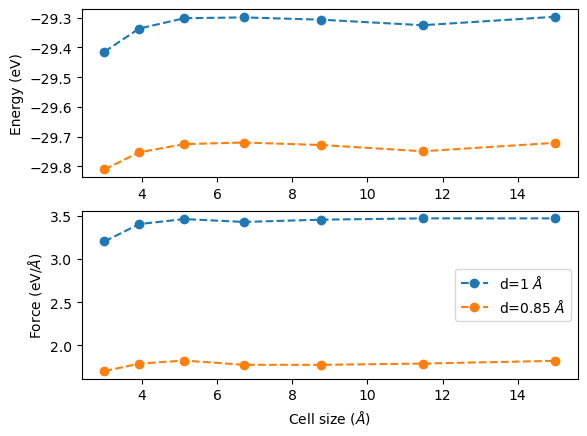

In [13]:
ax = subplot(211)
plot(cell_r[0], cell_r[1], 'o--', label='d=1 $\AA$')
plot(cell_r[0], cell_r[3], 'o--', label='d=0.85 $\AA$')
ylabel('Energy (eV)')

subplot(212, sharex=ax)
plot(cell_r[0], cell_r[2], 'o--', label='d=1 $\AA$')
plot(cell_r[0], cell_r[4], 'o--', label='d=0.85 $\AA$')
xlabel('Cell size ($\AA$)')
ylabel('Force (eV/$\AA$)')
legend();

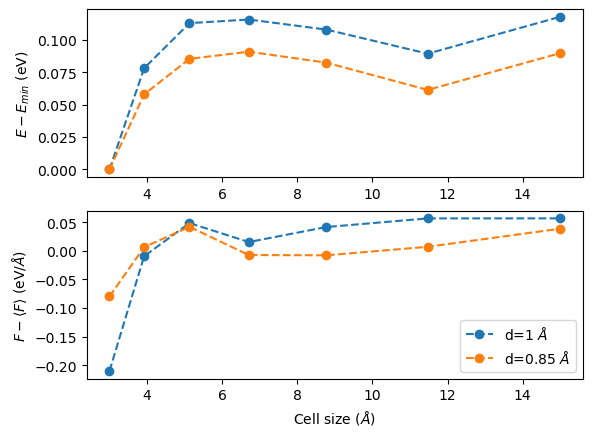

In [14]:
ax = subplot(211)
plot(cell_r[0], cell_r[1]-cell_r[1].min(), 'o--', label='d=1 $\AA$')
plot(cell_r[0], cell_r[3]-cell_r[3].min(), 'o--', label='d=0.85 $\AA$')
ylabel('$E - E_{min}$ (eV)')

subplot(212, sharex=ax)
plot(cell_r[0], cell_r[2]-cell_r[2].mean(), 'o--', label='d=1 $\AA$')
plot(cell_r[0], cell_r[4]-cell_r[4].mean(), 'o--', label='d=0.85 $\AA$')
ylabel(r'$F - \langle F \rangle$ (eV/$\AA$)')
xlabel('Cell size ($\AA$)')
legend();

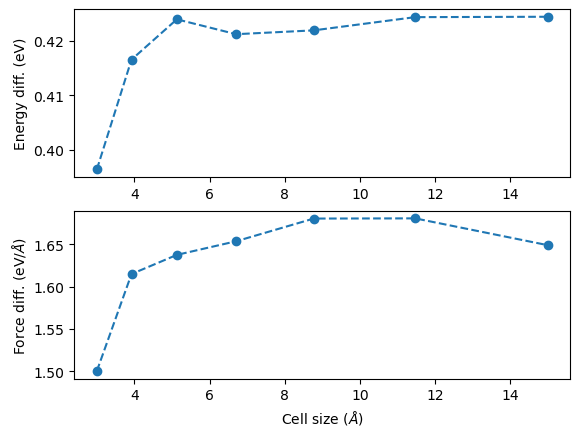

In [15]:
ax = subplot(211)
plot(cell_r[0], cell_r[1] - cell_r[3], 'o--')
ylabel('Energy diff. (eV)')

subplot(212, sharex=ax)
plot(cell_r[0], cell_r[2] - cell_r[4], 'o--')
ylabel('Force diff. (eV/$\AA$)')
xlabel('Cell size ($\AA$)');

## Rerun example from the first lecture

Now, when we have done convergence analysis and selected optimal calculation parameters we can rerun our calculation of H-H bond length for the determined set of parameters.

In [16]:
params['ecut']=150
H2.calc = Abinit(**params)
H2.set_cell([12,12,12])

EvsD = []
print(' d(A)   E(eV)  \n---------------------')
for d in np.linspace(0.6, 1, 5):
    H2.set_positions([(0,0,-d/2),(0,0,d/2)])
    E = H2.get_potential_energy()
    EvsD.append([d, E])
    print(f'{d:5.2f}: {E:6.2f}')
EvsD = np.array(EvsD).T

 d(A)   E(eV)  
---------------------
 0.60: -28.90
 0.70: -29.65
 0.80: -29.77
 0.90: -29.60
 1.00: -29.29


In [17]:
fit = polyfit(EvsD[0], EvsD[1], 4)

mpos = [real(r) for r in roots(fit[:-1] * np.arange(4,0,-1)) 
        if abs(imag(r))<1e-3 and real(r) < 1 and real(r) > 0.5][0]

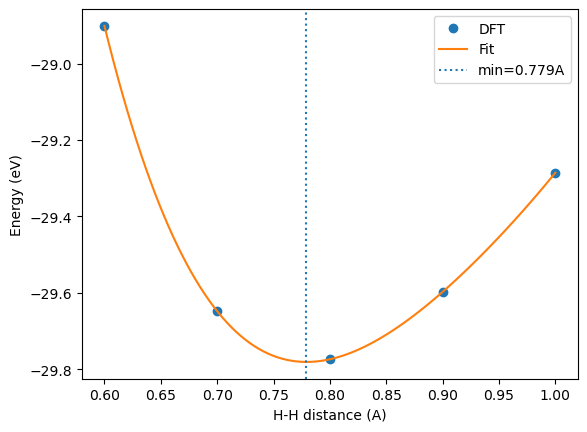

In [18]:
plot(EvsD[0], EvsD[1], "o", label='DFT')
d = linspace(0.6,1,100)
plot(d, np.polyval(fit, d), "-", label='Fit')
axvline(mpos, ls=':', label=f'min={mpos:.3f}A')
xlabel('H-H distance (A)')
ylabel('Energy (eV)')
legend();